### VAU-12 - Демонстрация работы модели inception автоенкодера 
#### Работу выполнил Вологин Никита Сергеевич

Задача модели, используемой в этом ноутбуке, состоит в определении аномальных значений, которые в контексте предметной области определены как блюда неправильной сервировки. 
В качестве рабочей гипотезы было сформулировано: "Ошибка реконструкции изображений, которые похожи на изображения, находящиеся в обучающем наборе данных, будет меньше, чем у изображений аномальной природы".

Данный ноутбук содержит демонстрационный код работы inception cae, обученных на наборах данных DSM-100 и DSM-50.

##### Импорт необходимых зависимостей

In [1]:
import numpy as np

from tensorflow import keras
from keras import saving as sv

import models.inception_autoencoder as inception_ae

import scripts.utilities as utl

##### Определение глобальных констант

In [2]:
BATCH_SIZE = 64
IMG_SIZE = 128
IMG_100_PATH = 'data/DSM-100/images'
ANO_IMG_100_PATH = 'data/DSM-100/ANO-DSM/uncorrect-meals/images'
ANO_IMG_100_PATH2 = 'data/DSM-100/ANO-DSM/unknown-meals/images'

IMG_50_PATH = 'data/DSM-50/images'
ANO_IMG_50_PATH = 'data/DSM-50/ANO-DSM/uncorrect-meals/images'
ANO_IMG_50_PATH2 = 'data/DSM-50/ANO-DSM/unknown-meals/images'

TEST_IMG_PATH = 'data/test-images/correct'
TEST_ANO_IMG_PATH = 'data/test-images/incorrect'

INC_MODEL_TEST_50_PATH = 'trained-models/inc_model_50_with_test.keras'
INC_MODEL_TEST_100_PATH = 'trained-models/inc_model_100_with_test.keras'

INC_MODEL_50_PATH = 'trained-models/dsm-50/inc_model_50.keras'
INC_MODEL_100_PATH = 'trained-models/dsm-100/inc_model_100.keras'

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
RANDOM_SEED = 42

#### Импорт, предобработка и аугментация данных

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.5, 1],
    validation_split=0.2)

ano_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_dataget = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [4]:
test_generator = test_dataget.flow_from_directory(
    TEST_IMG_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

test_ano_generator = test_dataget.flow_from_directory(
    TEST_ANO_IMG_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

Found 31 images belonging to 11 classes.
Found 31 images belonging to 11 classes.


In [5]:
train_generator_50 = train_datagen.flow_from_directory(
    IMG_50_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

valid_generator_50 = train_datagen.flow_from_directory(
    IMG_50_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='validation',
    seed=RANDOM_SEED
)

unknown_ano_generator_50 = ano_datagen.flow_from_directory(
    ANO_IMG_50_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

uncorrect_ano_generator_50 = ano_datagen.flow_from_directory(
    ANO_IMG_50_PATH2,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

Found 148 images belonging to 45 classes.
Found 7 images belonging to 45 classes.
Found 71 images belonging to 26 classes.
Found 349 images belonging to 55 classes.


In [6]:
train_generator_100 = train_datagen.flow_from_directory(
    IMG_100_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

valid_generator_100 = train_datagen.flow_from_directory(
    IMG_100_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='validation',
    seed=RANDOM_SEED
)

unknown_ano_generator_100 = ano_datagen.flow_from_directory(
    ANO_IMG_100_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

uncorrect_ano_generator_100 = ano_datagen.flow_from_directory(
    ANO_IMG_100_PATH2,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

Found 309 images belonging to 84 classes.
Found 26 images belonging to 84 classes.
Found 156 images belonging to 48 classes.
Found 115 images belonging to 22 classes.


#### Пример изображений блюд

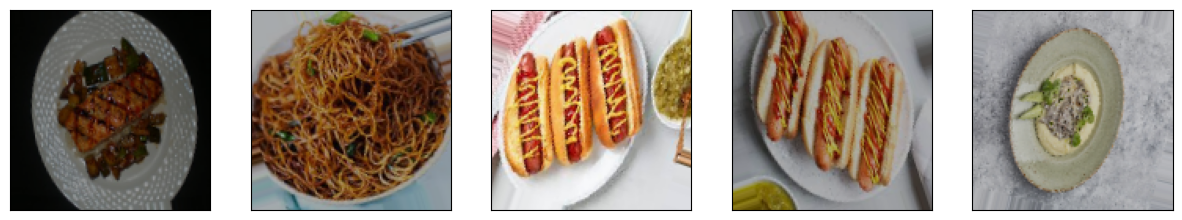

In [7]:
utl.plot_imgs(train_generator_100)

#### Загрузка и инициализация моделей

In [8]:
inc_model_50 = sv.load_model(INC_MODEL_50_PATH)
inc_model_100 = sv.load_model(INC_MODEL_100_PATH)

c:\Users\Nikit\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
inc_model_100.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mean_squared_error',
)
inc_model_50.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mean_squared_error',
)

#### Примеры реконструкции изображений

Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-100


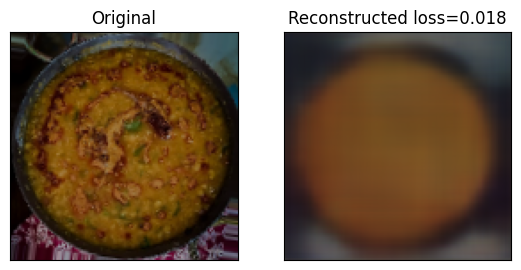

Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-50


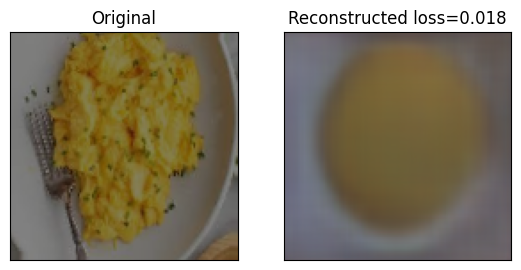

In [10]:
print('Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(valid_generator_100, 1, inc_model_100)

print('Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-50')
utl.plot_rec_imgs(valid_generator_50, 1, inc_model_50)

Пример реконструкции неизвестных блюд с помощью модели inception cae, обученной на наборе dsm-100


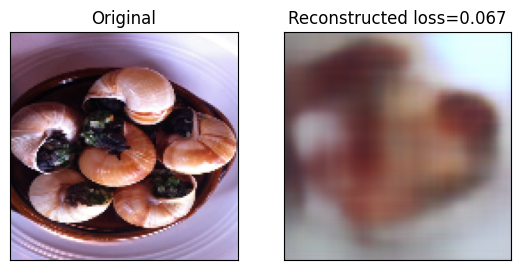

Пример реконструкции неизвестных блюд с модели inception cae, обученной на наборе dsm-50


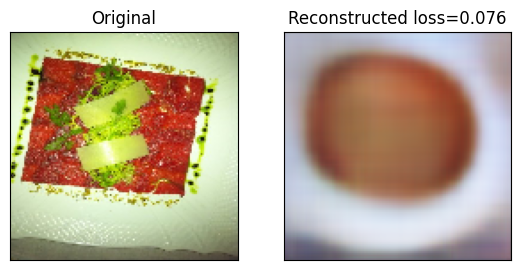

In [11]:
print('Пример реконструкции неизвестных блюд с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(unknown_ano_generator_100, 1, inc_model_100)

print('Пример реконструкции неизвестных блюд с модели inception cae, обученной на наборе dsm-50')
utl.plot_rec_imgs(unknown_ano_generator_50, 1, inc_model_50)

Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100


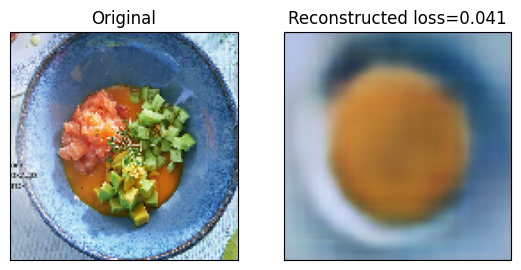

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50


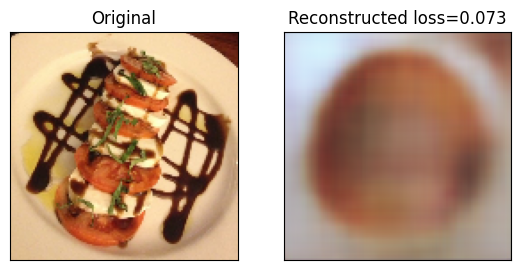

In [12]:
print('Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(uncorrect_ano_generator_100, 1, inc_model_100)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50')
utl.plot_rec_imgs(uncorrect_ano_generator_50, 1, inc_model_50)

Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100


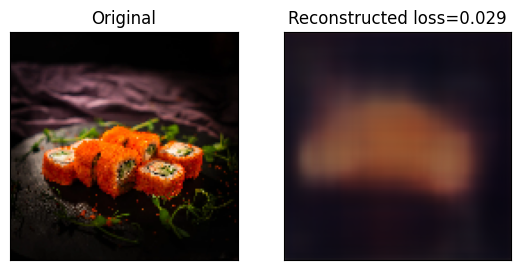

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50


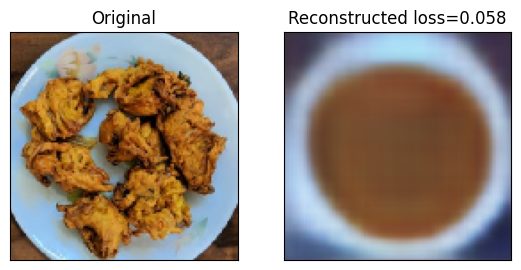

In [13]:
print('Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(uncorrect_ano_generator_100, 1, inc_model_100)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50')
utl.plot_rec_imgs(uncorrect_ano_generator_50, 1, inc_model_50)

Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100


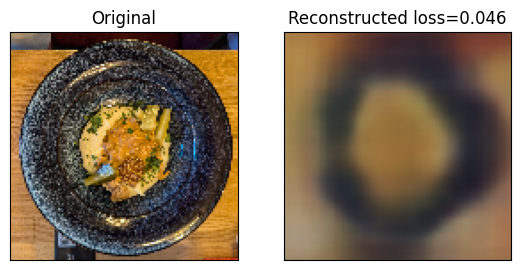

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-100


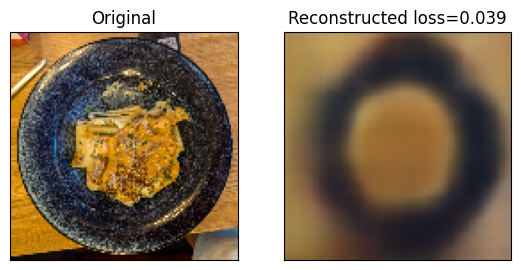

In [14]:
print('Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(test_generator, 1, inc_model_100)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-100')
utl.plot_rec_imgs(test_ano_generator, 1, inc_model_100)

Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-50


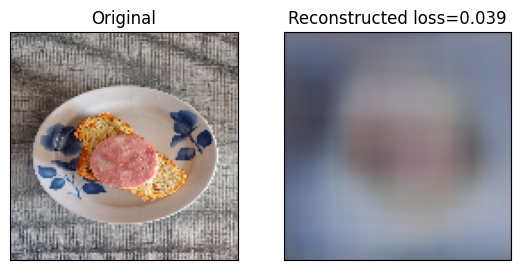

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50


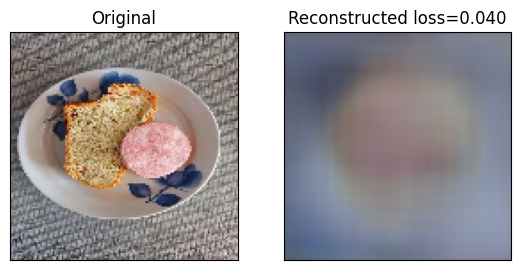

In [15]:
print('Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-50')
utl.plot_rec_imgs(test_generator, 1, inc_model_50)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50')
utl.plot_rec_imgs(test_ano_generator, 1, inc_model_50)

#### Вычисление ошибки реконструкции на каждом примере

##### DSM-100

In [16]:
train_recon_error_list = utl.get_error(train_generator_100, inc_model_100, BATCH_SIZE)
test_recon_error_list = utl.get_error(valid_generator_100, inc_model_100, BATCH_SIZE)

uncorrect_ano_recon_error_list = utl.get_error(uncorrect_ano_generator_100, inc_model_100, BATCH_SIZE)
unknown_ano_recon_error_list = utl.get_error(unknown_ano_generator_100, inc_model_100, BATCH_SIZE)

clean = np.append(test_recon_error_list, train_recon_error_list)
fraud = np.append(uncorrect_ano_recon_error_list, unknown_ano_recon_error_list)
threshold = np.mean(clean) + np.std(clean)

График ошибки распределения модели на наборе DSM-100


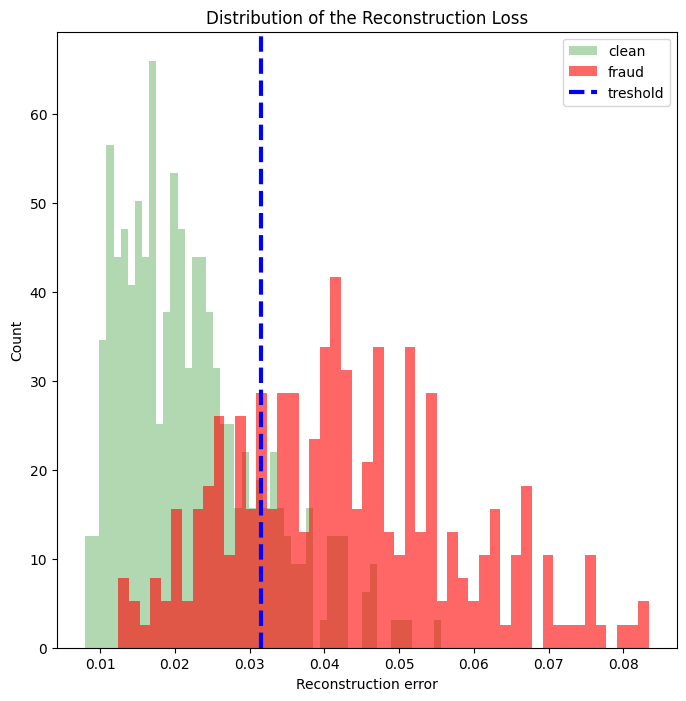

In [17]:
print('График ошибки распределения модели на наборе DSM-100')
utl.plot_rec_distribution(clean, fraud, threshold)

In [ ]:
a, b, c, d = utl.get_classification_metrics(clean, fraud, threshold)
utl.print_classification_metrics(a, b, c, d )

Распределение ошибки реконструкции на тестовых данных

In [18]:
ano_grechka_recon_error_list = utl.get_error(test_ano_generator, inc_model_100, BATCH_SIZE)
grechka_recon_error_list = utl.get_error(test_generator, inc_model_100, BATCH_SIZE)

График ошибки распределения модели, обученной на DSM-100, на тестовых данных


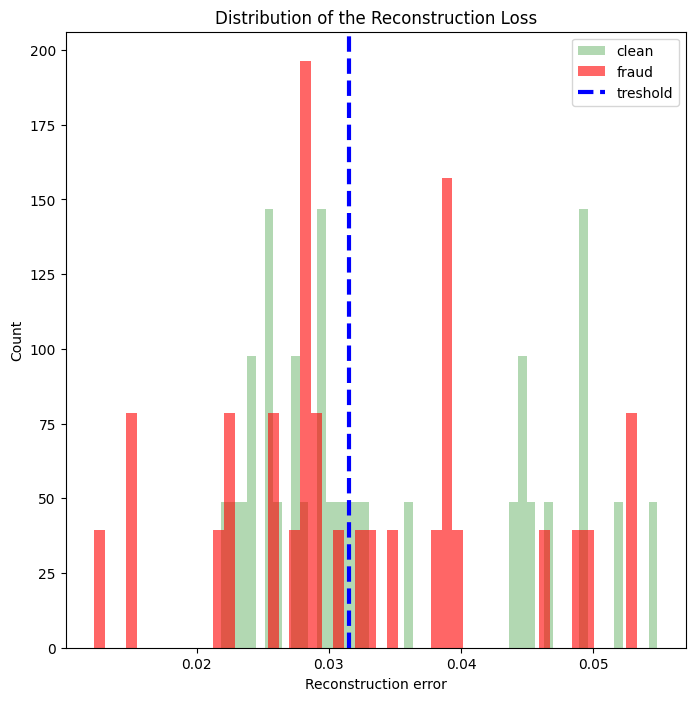

In [19]:
print('График ошибки распределения модели, обученной на DSM-100, на тестовых данных')
utl.plot_rec_distribution(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)

In [21]:
a, b, c, d = utl.get_classification_metrics(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)
utl.print_classification_metrics(a, b, c, d )

precisicon 0.514
recall 0.581
F 0.545
accuracy: 0.516


#### Промежуточный вывод

Распределения ошибки реконструкции пересекаются настолько, что провести классификацию нельзя 

In [22]:
train_recon_error_list = utl.get_error(train_generator_50, inc_model_50, BATCH_SIZE)
test_recon_error_list = utl.get_error(valid_generator_50, inc_model_50, BATCH_SIZE)

uncorrect_ano_recon_error_list = utl.get_error(uncorrect_ano_generator_50, inc_model_50, BATCH_SIZE)
unknown_ano_recon_error_list = utl.get_error(unknown_ano_generator_50, inc_model_50, BATCH_SIZE)

clean = np.append(test_recon_error_list, train_recon_error_list)
fraud = np.append(uncorrect_ano_recon_error_list, unknown_ano_recon_error_list)
threshold = np.mean(clean) + np.std(clean)

c:\Users\Nikit\AppData\Local\Programs\Python\Python39\lib\site-packages\pillow-9.5.0-py3.9-win-amd64.egg\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


График распределения ошибки модели на наборе DSM-50


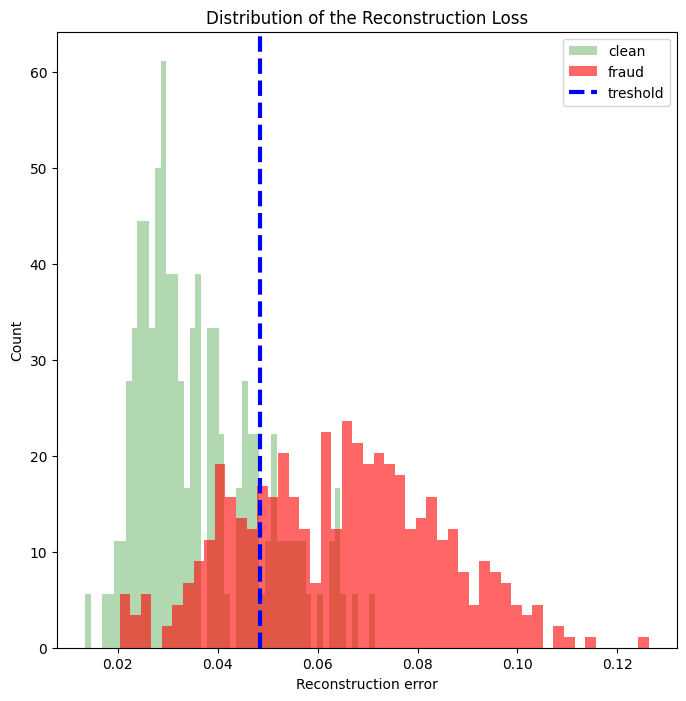

In [23]:
print('График распределения ошибки модели на наборе DSM-50')
utl.plot_rec_distribution(clean, fraud, threshold)

In [ ]:
a, b, c, d = utl.get_classification_metrics(clean, fraud, threshold)
utl.print_classification_metrics(a, b, c, d )

Распределение ошибки реконструкции на тестовых данных

In [24]:
grechka_recon_error_list = utl.get_error(test_generator, inc_model_50, BATCH_SIZE)
ano_grechka_recon_error_list = utl.get_error(test_ano_generator, inc_model_50, BATCH_SIZE)

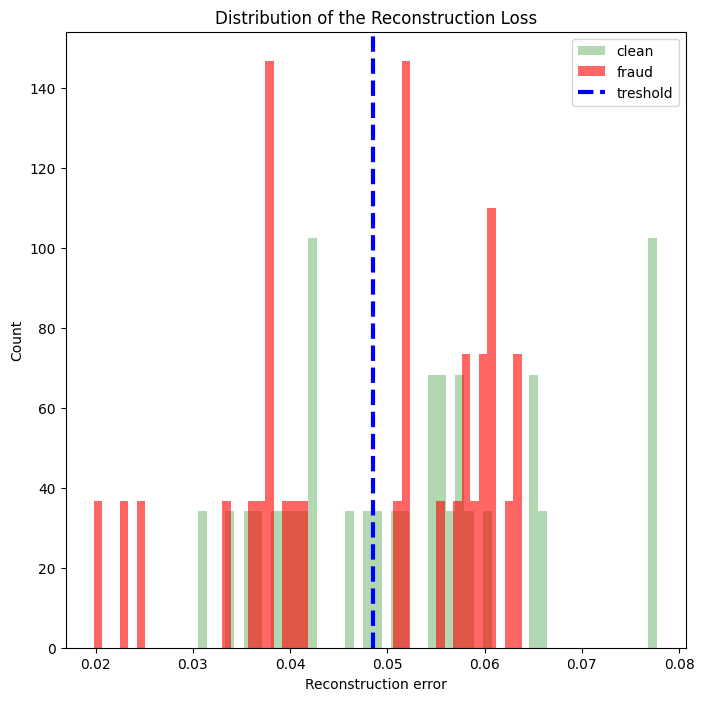

In [26]:
utl.plot_rec_distribution(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)

In [28]:
a, b, c, d = utl.get_classification_metrics(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)
utl.print_classification_metrics(a, b, c, d )

precisicon 0.500
recall 0.419
F 0.456
accuracy: 0.500


#### Промежуточный вывод

Данная модель так же не может отличить аномальные данные от нормальных.

#### Выводы

* Точность классификации обеих моделей на основных наборах составляет около ~0.8 
* Точность классификации тестовых примеров находится на неприемлимом уровне.

Как и ожидалось на этапе обучения этой модели, она вышла сильно переобученной, и результаты на тестовых не аномальных примерах имеют высокую ошибку реконструкции, из-за чего установить разницу между нормальными и аномальными данными можно только с плохой точностью.

Возможно стоит пересмотреть архитектуру этой модели, уменьшив количество слоёв или или увеличив размер латентного вектора, чтобы модель могла реконструировать больше информации. Помимо этого, необходимо предпринять меры для того, чтобы модель переобучалась не так сильно. 